# Ejercicio 2: Delfines

In [72]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import os

In [73]:
# Leemos el archivo
myFolder=(os.getcwd()+'/tc01_data/') #busca en el directorio actual

# Primero creamos la red de delfines: agregamos los enlaces sin necesidad de agregar antes los nodos
mydolphins = nx.read_gml(myFolder+'new_dolphins.gml')

# Para agregar el dato del genero a partir del txt:
# creamos dos listas: una de nombres de delfines (nodos) y otra de los generos correspondientes
Gender = pd.read_csv(myFolder+'dolphinsGender.txt', sep='\t', header=None)
delfines = Gender[0] # nombres de delfines (nodos)
genero = Gender[1]   # genero de los delfines en el mismo orden que los nodos

# A cada uno de los nodos ya existentes en el grafo, se le agrega el genero
for d,g in zip(delfines,genero):
    mydolphins.add_node(d, gender=g)

# Por ejemplo para ver la prop genero en el delfin 'Jet'
# print(mydolphins.nodes['Jet']['gender'])


## Tipos de layout
Generamos gráficos con distintos layouts.
Los nodos azules son de género masculino, los rojos de género femenino, y los verdes NA

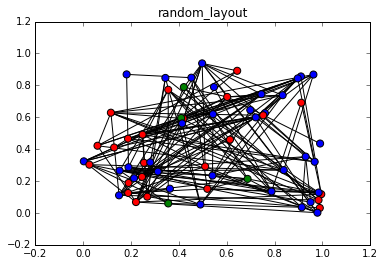

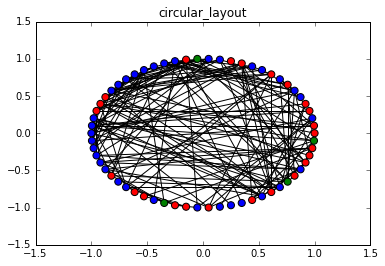

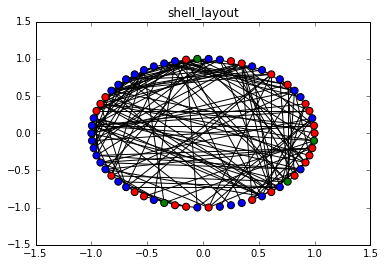

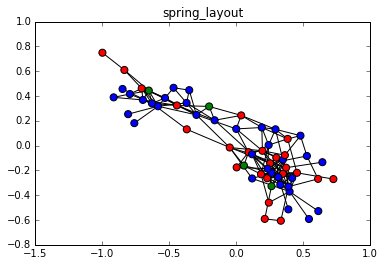

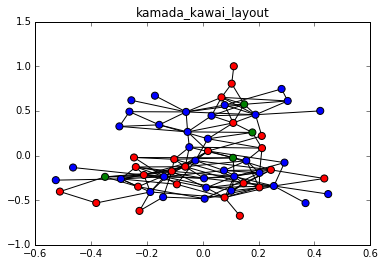

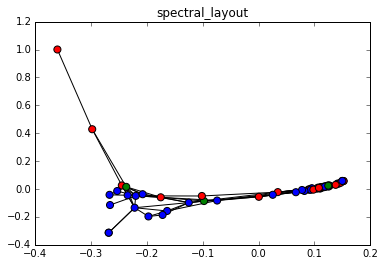

In [4]:
layouts=['random_layout','circular_layout','shell_layout','spring_layout','kamada_kawai_layout','spectral_layout']
# fruchterman reingold no está incluido porque es el algoritmo que usa spring

for f,lay in enumerate(layouts):
 plt.figure(f)
 nx.draw_networkx(mydolphins,eval('nx.'+lay)(mydolphins),
        width=1,
        node_color=["blue" if g=="m" else "red" if g=="f" else "green" for g in nx.get_node_attributes(mydolphins, "gender").values()], 
        node_size=50,
        with_labels=False
       )
 plt.title(lay)
plt.show()



Los layouts shell y circular son iguales en este caso, porque el grafo es conexo. Si hubiese varios subgrafos conexos, shell los graficaría como cáscaras o capas. Ya que ninguno de los layouts permite identificar patrones, este es el más fácil de leer.

## Análisis de homofilia

In [28]:
Enlaces_fm = [] # Lista donde vamos a almacenar la cantidad de enlaces entre géneros distintos

# Hacemos N asignaciones aleatorias de género:
num_asignaciones = 5000

for it in range(num_asignaciones):
    if it==0:
        genero_shuffle = genero # Conservamos la red real en la primera iteración
    else:
        genero_shuffle = genero
        np.random.shuffle(genero_shuffle) # Reordenamos aleat los generos para el resto de las iteraciones

    # Reasignamos a cada nodo un valor de genero del vector de genero_shuffle:
    for d,g in zip(delfines,genero_shuffle):
        mydolphins.add_node(d, gender=g)
        
    #Contamos la fraccion de enlaces que conecta nodos con diferente genero:
    enlaces = list(mydolphins.edges.data())
    enlaces_fm = 0 # Ponemos en cero el contador de enlaces cruzados
    # Recorremos los enlaces y nos fijamos cual de ellos es del tipo f-m:
    for i in range(0,len(enlaces)-1):
        genero1 = mydolphins.nodes[enlaces[i][0]]['gender']
        genero2 = mydolphins.nodes[enlaces[i][1]]['gender']
        if genero1 != genero2:   # Comparamos los generos
            enlaces_fm += 1 # Incrementamos el contador si los generos son diferentes
    Enlaces_fm.append(enlaces_fm) # Guardamos la cantidad de enlaces f-m en cada iteración

# Ahora tenemos una lista Enlaces_fm con la cantidad de enlaces cruzados para N iteraciones
# Recordamos que la primera componente corresponde a la red real

# Valor medio y desviacion standar
mean_enlacesfm = np.mean(Enlaces_fm)
desv_enlacesfm = np.std(Enlaces_fm)

print ('Distribucion de enlaces fm:')
print ('Valor medio(H null): {0:.2f}'.format(mean_enlacesfm))
print ('Desviacion Standar: {0:.2f}'.format(desv_enlacesfm))
print ('Valor Red Real: {0:.2f}'.format(Enlaces_fm[0]))


Distribucion de enlaces fm:
Valor medio(H null): 87.98
Desviacion Standar: 6.28
Valor Red Real: 62.00


p valor: 1.1102230246251565e-16


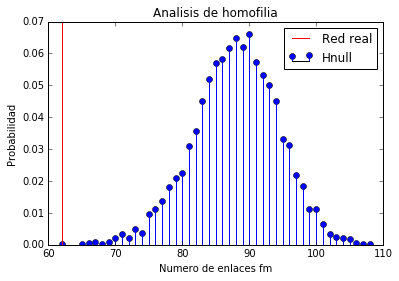

In [32]:
# Histograma y p-valor:
histograma = np.unique(Enlaces_fm,return_counts=True)
k_enlacesfm = histograma[0] # El vector cantidad de enlaces fm, ordenado
probabilidad = histograma[1]/float(num_asignaciones) # Cantidad de veces que aparece cada valor de enlaces, normalizado

# p-valor: la probabilidad que queda acumulada a la izq del numero de enlaces_fm de la red real
# Buscamos el k_enlacesfm mas cercano al de la red real
closestto = Enlaces_fm[0]
theclosest = min(histograma[0], key=lambda x:abs(x-closestto)) # devuelve el k_enlacesfm más cercano al valor real
theclosest_index = int(np.where(histograma[0] == theclosest)[0]) # devuelve el indice correspondiente al valor anterior

# Sumamos las probabilidades desde el mas cercano hasta el ultimo hacia la derecha
pvalue=1-np.sum(probabilidad[theclosest_index :])
print ('p valor: {}'.format(pvalue))


plt.figure()
plt.stem(k_enlacesfm,probabilidad, basefmt='k', label='Hnull')
plt.axvline(Enlaces_fm[0], c="red",label='Red real') # Linea vertical en el valor de la red real
plt.xlabel('Numero de enlaces fm')
plt.ylabel('Probabilidad')
plt.title('Analisis de homofilia')
plt.legend()
plt.show() 



Podemos concluir que hay homofilia de género, ya que la cantidad de enlaces entre distintos géneros es mucho menor que la que se esperaría al azar. 
En este caso, en lugar de contar los enlaces entre un mismo género y sumarlos, para ahorrarnos cuentas pudimos contar los enlaces cruzados. Esto se debe a que sólo existen dos géneros. De hecho, lo correcto sería eliminar los nodos sin género antes de realizar esta cuenta, ya que no se pueden considerar como parte de la estadística si no sabemos que tipo de enlace aportan.

In [35]:
# Repetimos la cuenta sin los delfines con género NA, para ver si se modifica de manera apreciable
#Delfines sin genero
delfines=[d for i,d in enumerate(Gender[0]) if type(Gender[1][i]) is not float]
genero=[g for i,g in enumerate(Gender[1]) if type(Gender[1][i]) is not float]
delfines_remove= [d for i,d in enumerate(Gender[0]) if type(Gender[1][i]) is float]    

# A cada uno de los nodos se le agrega el genero y ademas eliminamos los delfines sin genero:
for d,g in zip(delfines,genero):    
    mydolphins.add_node(d, gender=g)

for d in delfines_remove:
    mydolphins.remove_node(d)
    
Enlaces_fm = [] # Lista donde vamos a almacenar la cantidad de enlaces entre géneros distintos

# Hacemos N asignaciones aleatorias de género:
num_asignaciones = 5000

for it in range(num_asignaciones):
    if it==0:
        genero_shuffle = genero # Conservamos la red real en la primera iteración
    else:
        genero_shuffle = genero
        np.random.shuffle(genero_shuffle) # Reordenamos aleat los generos para el resto de las iteraciones

    # Reasignamos a cada nodo un valor de genero del vector de genero_shuffle:
    for d,g in zip(delfines,genero_shuffle):
        mydolphins.add_node(d, gender=g)
        
    #Contamos la fraccion de enlaces que conecta nodos con diferente genero:
    enlaces = list(mydolphins.edges.data())
    enlaces_fm = 0 # Ponemos en cero el contador de enlaces cruzados
    # Recorremos los enlaces y nos fijamos cual de ellos es del tipo f-m:
    for i in range(0,len(enlaces)-1):
        genero1 = mydolphins.nodes[enlaces[i][0]]['gender']
        genero2 = mydolphins.nodes[enlaces[i][1]]['gender']
        if genero1 != genero2:   # Comparamos los generos
            enlaces_fm += 1 # Incrementamos el contador si los generos son diferentes
    Enlaces_fm.append(enlaces_fm) # Guardamos la cantidad de enlaces f-m en cada iteración

# Ahora tenemos una lista Enlaces_fm con la cantidad de enlaces cruzados para N iteraciones
# Recordamos que la primera componente corresponde a la red real

# Valor medio y desviacion standar
mean_enlacesfm = np.mean(Enlaces_fm)
desv_enlacesfm = np.std(Enlaces_fm)

print ('Distribucion de enlaces fm:')
print ('Valor medio(H null): {0:.2f}'.format(mean_enlacesfm))
print ('Desviacion Standar: {0:.2f}'.format(desv_enlacesfm))
print ('Valor Red Real: {0:.2f}'.format(Enlaces_fm[0]))


Distribucion de enlaces fm:
Valor medio(H null): 72.55
Desviacion Standar: 5.86
Valor Red Real: 51.00


p valor: 0.0006


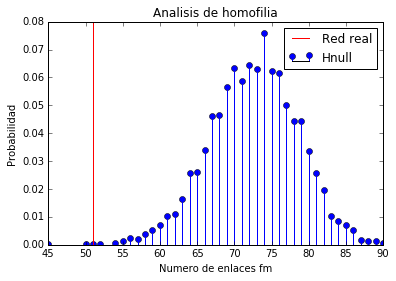

In [36]:
# Histograma y p-valor:
histograma = np.unique(Enlaces_fm,return_counts=True)
k_enlacesfm = histograma[0] # El vector cantidad de enlaces fm, ordenado
probabilidad = histograma[1]/float(num_asignaciones) # Cantidad de veces que aparece cada valor de enlaces, normalizado

# p-valor: la probabilidad que queda acumulada a la izq del numero de enlaces_fm de la red real
# Buscamos el k_enlacesfm mas cercano al de la red real
closestto = Enlaces_fm[0]
theclosest = min(histograma[0], key=lambda x:abs(x-closestto)) # devuelve el k_enlacesfm más cercano al valor real
theclosest_index = int(np.where(histograma[0] == theclosest)[0]) # devuelve el indice correspondiente al valor anterior

# Sumamos las probabilidades desde el mas cercano hasta el ultimo hacia la derecha
pvalue=1-np.sum(probabilidad[theclosest_index :])
print ('p valor: {0:.4f}'.format(pvalue))


plt.figure()
plt.stem(k_enlacesfm,probabilidad, basefmt='k', label='Hnull')
plt.axvline(Enlaces_fm[0], c="red",label='Red real') # Linea vertical en el valor de la red real
plt.xlabel('Numero de enlaces fm')
plt.ylabel('Probabilidad')
plt.title('Analisis de homofilia')
plt.legend()
plt.show() 

Ahora eliminando los nodos sin género, se ve que la distribución de enlaces mixtos posee una media menor(lo cual es razonable puesto que se han eliminado enlaces junto con esos nodos) y aún así se obtuvo un p-valor de 0.0006, el cual es un valor pequeño que nos sigue indicando que hay homofilia en la red de delfines.

## Cómo desarmar la red

Nuestra idea para antes de realizar el análisis es que va a convenir eliminar nodos de menor clustering, porque esto significa que eliminamos nodos cuyos vecinos no están conectados entre sí, y por lo tanto se debería separar el grafo. También se puede pensar que conviene eliminar nodos de mayor a menor grado, porque son los que más conexiones tienen. Por esta razón, consideramos otra posibilidad que tuviera en cuenta tanto el grado (alto) como el clustering (bajo).

Comparamos distintas estrategias para decidir cuál era la forma más eficiente de sacar nodos (m = menor, M = Mayor):
#1- De m a M grado (G)
#2- De M a m grado (G)
#3- De m a M coef de clustering (C)
#4- De M a m coef de clustering (C)
#5- Según un nueva variable que definimos como CG=clustering/grado: de menor a Mayor CG


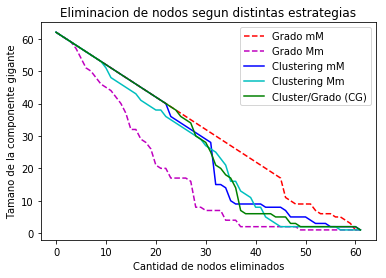

In [23]:
# Creamos una copia de la red de delfines
dolphins_copy = nx.read_gml(myFolder+'dolphins.gml')

# Diccionarios con los coeficientes de clustering y el grado correspondientes a cada delfin
coef = nx.clustering(dolphins_copy)
grado = dict(dolphins_copy.degree())

# Lista de delfines ordenada de menor a Mayor, por coef de clustering  y por grado
C_orden_mM=sorted(coef, key=coef.__getitem__)
G_orden_mM=sorted(grado, key=grado.__getitem__)

# Lista de delfines ordenada de Mayor a menor, por coef de clustering y por grado
C_orden_Mm=sorted(coef, key=coef.__getitem__,reverse=True)
G_orden_Mm=sorted(grado, key=grado.__getitem__,reverse=True)


# Para hacer un grafico del tamaño de componente gigante en funcion de nodos eliminados:

L = len(dolphins_copy) # tamaño del grafo (cantidad de nodos)
nodos_elim = np.arange(L) # vector que va del 0 al L-1, cantidad de nodos que se va a ir eliminando (eje x)

comp_size_C_mM = np.ones(L) # vector de 1s que se va a ir llenando con el tamaño de la componente gigante (eje y)
comp_size_C_mM[0] = L # la primera componente es el tamaño original del grafo

comp_size_G_mM = np.ones(L) # vector de 1s que se va a ir llenando con el tamaño de la componente gigante
comp_size_G_mM[0] = L # la primera componente es el tamaño del grafo

comp_size_C_Mm = np.ones(L) # vector de 1s que se va a ir llenando con el tamaño de la componente gigante
comp_size_C_Mm[0] = L # la primera componente es el tamaño original del grafo

comp_size_G_Mm = np.ones(L) # vector de 1s que se va a ir llenando con el tamaño de la componente gigante
comp_size_G_Mm[0] = L # la primera componente es el tamaño del grafo

#1- De m a M grado(k)
for i in range(L-1):
    dolphins_copy.remove_node(G_orden_mM[i])
    comp_size_G_mM[i+1] = len(max(nx.connected_component_subgraphs(dolphins_copy),key=len))

#2- De M a m grado(k)
dolphins_copy = nx.read_gml(myFolder+'dolphins.gml')
for i in range(L-1):
    dolphins_copy.remove_node(G_orden_Mm[i])
    comp_size_G_Mm[i+1] = len(max(nx.connected_component_subgraphs(dolphins_copy),key=len))

#3-De m a M coef de clustering(C)
dolphins_copy = nx.read_gml(myFolder+'dolphins.gml')
for i in range(L-1):
    dolphins_copy.remove_node(C_orden_mM[i])
    comp_size_C_mM[i+1] = len(max(nx.connected_component_subgraphs(dolphins_copy),key=len))
    
#4-De M a m coef de clustering(C)
dolphins_copy = nx.read_gml(myFolder+'dolphins.gml')
for i in range(L-1):
    dolphins_copy.remove_node(C_orden_Mm[i])
    comp_size_C_Mm[i+1] = len(max(nx.connected_component_subgraphs(dolphins_copy),key=len))

    
# Diccionario
dolphins_copy = nx.read_gml(myFolder+'dolphins.gml')
Gender = pd.read_csv(myFolder+'dolphinsGender.txt', sep='\t', header=None)
delfines= Gender[0] # nombres de delfines (nodos)
coefCG = {}

for i,delfin in enumerate(delfines):
    coefCG[delfin] = coef[delfin] / grado[delfin] # Agrega al diccionario delfin con clustering/grado

# Lista ordenada de ese nuevo coeficiente
clust_grado = sorted(coefCG, key=coefCG.__getitem__)

comp_size_CG = np.ones(L) # vector de 1s que se va a ir llenando con el tamaño de la componente gigante (eje y)
comp_size_CG[0] = L # la primera componente es el tamaño original del grafo

#5- Segun un nueva variable que definimos como CG=clustering/grado, y eliminamos de menor a mayor CG
for i in range(L-1):
    dolphins_copy.remove_node(clust_grado[i])
    comp_size_CG[i+1] = len(max(nx.connected_component_subgraphs(dolphins_copy),key=len))


plt.figure(2)

plt.plot(nodos_elim,comp_size_G_mM,'--r',label='Grado mM')
plt.plot(nodos_elim,comp_size_G_Mm,'--m',label='Grado Mm')
plt.plot(nodos_elim,comp_size_C_mM,'-b',label='Clustering mM')
plt.plot(nodos_elim,comp_size_C_Mm,'-c',label='Clustering Mm')
plt.plot(nodos_elim,comp_size_CG,'-g',label='Cluster/Grado (CG)')

plt.xlabel('Cantidad de nodos eliminados')
plt.ylabel('Tamano de la componente gigante')
plt.title('Eliminacion de nodos segun distintas estrategias')
plt.legend()
plt.show()

Recordando, nosotros suponíamos que la forma más eficiente de desarmar la red sería con ese nuevo coeficiente que tiene en cuenta tanto el coef de clustering como el grado. Se puede ver de manera decepcionante que esto no es así. La forma más rápida es la más simple: eliminando nodos de Mayor a menor grado (es decir los nodos más conectados).

# Extra: Asortividad por género

Queremos tener otra medida de la homofilia y para eso quisimos calcular la asortividad según la variable categórica género.

In [74]:
#Delfines sin genero
delfines=[d for i,d in enumerate(Gender[0]) if type(Gender[1][i]) is not float]
genero=[g for i,g in enumerate(Gender[1]) if type(Gender[1][i]) is not float]
delfines_remove= [d for i,d in enumerate(Gender[0]) if type(Gender[1][i]) is float]    

# A cada uno de los nodos se le agrega el genero y ademas eliminamos los delfines sin genero:
for d,g in zip(delfines,genero):    
    mydolphins.add_node(d, gender=g)

for d in delfines_remove:
    mydolphins.remove_node(d)

In [138]:
#Matriz de Adyacencias Aij:
delfines=np.sort(delfines)
A = np.array(nx.to_numpy_matrix(mydolphins,nodelist=delfines))
N=mydolphins.number_of_nodes()
m=mydolphins.number_of_edges()
grado = dict(mydolphins.degree())

#Matriz de variable categorica genero: Cij=delta(ci,cj)
C=np.zeros(np.shape(A))
for ni, idelfin in enumerate(delfines):
    for nj, jdelfin in enumerate(delfines):
        if mydolphins.nodes[idelfin]['gender']==mydolphins.nodes[jdelfin]['gender']:
            C[ni,nj]=1

#Calculo de la modularidad
#Q/Qmax=(S1-S2)/(2m-S2)

#S1=Suma en nodos (Aij*Cij)
#S2=Suma en nodos(kikj*Cij/2m)
S1=0
S2=0
for ni, idelfin in enumerate(delfines):
    for nj, jdelfin in enumerate(delfines):  
        S1=S1+A[ni,nj]*C[ni,nj]
        S2=S2+grado[idelfin]*grado[jdelfin]*C[ni,nj]
S2=S2/(2*m)
mod=(S1-S2)/(2*m-S2)

print('Modularidad Q/Qmax = {0:.3f}'.format(mod))
    



            




Modularidad Q/Qmax = 0.278


Vemos que la modularidad es otro valor que puede hablarnos de la homofilia. En este caso, al ser un valor positivo entre 0 y 1, nos dice que hay más enlaces entre vértices del mismo género que los esperados por azar.